# INDEX
1. `Import`
2. `Function` : 사용할 함수 파트
3. `Data Load` : 데이터를 불러오고, train df 의 경우 StratifiedKFold 학습을 위해 미리 fold feature 생성
4. `Feature engineering`  
    FE 파트. 특정 FE 는 오래걸리므로 pickle dump, load 사용하여 시간 단축.  
    오래걸리는 FE 는 pickle dump 상위에 배치
5. `Feature selection`  
    학습에 이용할 Feature 선택
6. `Modeling and Training with Cross Validation`  
    modeling and training  
    변수 **STRATIFY_TRAINING** : `True` or `False` 에 따라 Stratifying 학습을 할 지, train_valid 학습을 할 지 선택.
7. `Prediction 분석` : 예측한 값을 분석합니다.
8. `TO DO` : 개선파트 기록

# 1. Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
import os
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
from time import time
import time
import datetime
from datetime import datetime
import pickle
from glob import glob
from tqdm import tqdm

filterwarnings('ignore')
pd.options.display.max_columns = 999

# 2. Function

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(59)

def custom_train_test_split(df, ratio=0.7, split=True): 
    '''
    사용자 기준으로 묶어서 분리함.
    
    :param df: dataframe
    :param ratio: 전체 interaction 데이터 대비 비율
    :param split: True 
    
    :return: 
            train : train 데이터
            test : valid 데이터 (마지막 interaction 만 추출)
    '''
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
# 사용자별로 묶음과 동시에 사용자별 문제풀이 수를 고려하여 Stratify 분리 (Stratifying CV 학습과 동시 고려)
def make_train_valid_skf(train, n_split=5):
    '''
    데이터에서 문제를 많이 풀 수록 정답률이 올라가므로, 푼 문제 수에 대해서도 균등한 분리를 해주어야 정확한 학습.
    shuffle + 문제풀이 수 고려하여 분리.
    
    :param train: 학습을 위한 train 데이터
    :param n_split: Stratify split number
    
    :return: 
            균등하게 fold 가 구성된 train df
    '''
    skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=43)
    
    train_stratify = train['userID'].value_counts().to_frame('num')
    train_stratify['group'] = train_stratify['num']//170
    train_stratify['fold'] = 0
    
    for i, (train_index, valid_index) in enumerate(skf.split(train_stratify, train_stratify.group)):
        train_stratify.loc[train_stratify.iloc[valid_index].index, 'fold'] = i

    train_stratify.reset_index(inplace=True)
    train_stratify.rename(columns = {'index':'userID'}, inplace=True)
    train = pd.merge(train, train_stratify[['userID','fold']], how='left', on = 'userID')
    return train

In [7]:
FEATURES = []
def split_kfold(train, test, fold_num, FEATS=FEATURES):
    '''
    Fold 에 따라 train/valid set 을 나누고 학습과 추론에 필요한 dataframe 을 구축하는 함수
    
    :param train: train df
    :param test: test df
    :param fold_num: train/valid set 을 구분하기 위한 KFold number
    :param FEATS: 학습에 사용할 FEATURES
    
    :return: 
            X_train_df, y_train, X_valid_df, y_valid, test_df
    '''
    
    X_train = train[train['fold'] != fold_num]
    X_valid = train[train['fold'] == fold_num]
    X_valid = X_valid[X_valid['userID'] != X_valid['userID'].shift(-1)]
    test = test[test['userID'] != test['userID'].shift(-1)]
    # 사용할 Feature 설정 (기존 baseline 은 numeric data 만 이용)
    # FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
    #          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

    FEATS = FEATURES

    y_train = X_train['answerCode']
    X_train = X_train.drop(['answerCode'], axis=1)

    y_valid = X_valid['answerCode']
    X_valid = X_valid.drop(['answerCode'], axis=1)

    test = test.drop(['answerCode'], axis=1)

#     print(f"X_train    : {str(X_train.shape):15s} / y_train : {y_train.shape}")
#     print(f"X_valid    : {str(X_valid.shape):15s} / y_valid : {y_valid.shape}")
#     print(f"test       : {str(test.shape):15s}")

#     lgb_train = lgb.Dataset(X_train[FEATS], y_train)
#     lgb_valid = lgb.Dataset(X_valid[FEATS], y_valid)
    X_train_df = X_train[FEATS]
    X_valid_df = X_valid[FEATS]
    test_df = test[FEATS]

#     print(f"\nUse FEATURES : {FEATS}\n")

#     print(f"X_train_df : {str(X_train_df.shape):15s} / y_train : {y_train.shape}")
#     print(f"X_valid_df : {str(X_valid_df.shape):15s} / y_valid : {y_valid.shape}")
#     print(f"test_df    : {str(test_df.shape):15s}")
    
    return X_train_df, y_train, X_valid_df, y_valid, test_df

In [8]:
def write_pickle(data, file):    
    '''
    pickle 로 덮어쓰기
    
    :param data: dataframe
    :param file: file 이름
    
    :return: 
            None
    '''
    pickle_path = os.path.join(data_dir, f'{file}_data.pickle')
    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_pickle(file):
    '''
    pickle 파일 불러오기
    
    :param file: file 이름
    
    :return: 
            file 이름에 해당하는 dataframe 반환
    '''
    
    pickle_path = os.path.join(data_dir, f'{file}_data.pickle')
    if pickle_path in glob(data_dir + '/*'):
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
    return data

In [9]:
def distribution_draw(y_valid, valid_result):
    '''
    valid_y_true 값과 valid 예측값을 인수로 받아 분포를 그리는 함수
    
    :param y_valid: y_true 값
    :param valid_result: valid 예측값
    
    :return:
        check_pred: 예측값과 true 값에 해당하는 dataframe 을 반환
        check_zero: check_pred 중 true 값이 0 인 df 를 반환
        check_one: check_pred 중 true 값이 1 인 df 를 반환
    '''
    check_pred = pd.DataFrame(y_valid)
    check_pred.rename(columns = {'answerCode':'answer'}, inplace=True)
    check_pred['pred'] = valid_result
    check_zero = check_pred[check_pred['answer'] == 0].sort_values(by=['pred'], ascending=False)
    check_one = check_pred[check_pred['answer'] == 1].sort_values(by=['pred'])

    plt.figure(figsize=(16,5))
    plt.hist(list(check_zero['pred']), 
             bins=20, 
             rwidth=0.9, 
             label='pred zero', 
             alpha = 0.5);
    plt.hist(list(check_one['pred']), 
             bins=20, 
             rwidth=0.9, 
             label='pred one',
             alpha = 0.5);
    plt.legend(loc='upper left')
    plt.title('Prediction for 0 and 1 - Distribution', 
              fontweight='bold', 
              loc='left', size=20)
    plt.show();
    return check_pred, check_zero, check_one

----
# 3. Data Load

In [10]:
%%time
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
sub_csv_file_path = os.path.join(data_dir, 'sample_submission.csv')

train = pd.read_csv(csv_file_path) 
test = pd.read_csv(test_csv_file_path)

# Fold group 생성
train = make_train_valid_skf(train, n_split=5)

display(train.head(), train.shape, test.head(), test.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0


(2266586, 7)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


(260114, 6)

CPU times: user 3.6 s, sys: 68 ms, total: 3.66 s
Wall time: 3.67 s


# 4. FEATURE ENGINEERING
1. 숫자 통계량 추가
2. 카테고리 통계량 추가
3. 숫자 + 카테고리 통계량 추가
4. 교호작용
5. Feature engineering (ex-lag feature, time series)

In [363]:
%%time
# 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
train.sort_values(by=['userID', 'Timestamp'], inplace=True)
test.sort_values(by=['userID', 'Timestamp'], inplace=True)

CPU times: user 6.96 s, sys: 332 ms, total: 7.3 s
Wall time: 7.3 s


In [364]:
%%time
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

train['time'] = train['Timestamp'].apply(convert_time)
test['time'] = test['Timestamp'].apply(convert_time)

CPU times: user 37 s, sys: 3.33 s, total: 40.3 s
Wall time: 40.6 s


In [365]:
train['time'] = train['time'] - train['time'].shift(1)
test['time'] = test['time'] - test['time'].shift(1)
train.loc[0, 'time'] = 0
test.loc[0,'time'] = 0
# 숫자가 큰 값은 아직 처리하지 않고 테스트 해보자.

In [366]:
train['testId'] = train['testId'].apply(lambda x: int(x[2:]))
test['testId'] = test['testId'].apply(lambda x: int(x[2:]))

train['temp_test'] = train['testId'].shift(1)
train.loc[0,'temp_test'] = 0
test['temp_test'] = test['testId'].shift(1)
test.loc[0,'temp_test'] = 0

train['temp_test'] = train['temp_test'] - train['testId']
test['temp_test'] = test['temp_test'] - test['testId']

In [367]:
train['temp_test'] = train['temp_test'].apply(lambda x: 0 if x != 0.0 else 1)
train['time'] = train['time'] * train['temp_test']
train['time_cum'] = train.groupby(['userID','testId'])['time'].transform(lambda x: x.cumsum())

test['temp_test'] = test['temp_test'].apply(lambda x: 0 if x != 0.0 else 1)
test['time'] = test['time'] * test['temp_test']
test['time_cum'] = test.groupby(['userID','testId'])['time'].transform(lambda x: x.cumsum())

In [368]:
write_pickle(train, 'train')
write_pickle(test, 'test')
print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")

train shape : (2266586, 10)
test shape : (260114, 9)


----
`시간이 오래걸리는 FE 는 pickle 위에 추가하고 pickle 로 덮어씌우기`

In [534]:
train = load_pickle('train')
test = load_pickle('test')
print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")
train['Timestamp'] = train['Timestamp'].astype('datetime64')
test['Timestamp'] = test['Timestamp'].astype('datetime64')

# 통계량 추출을 위한 test_set dataFrame
test_stat = test[(test['answerCode'] == 0) | (test['answerCode'] == 1)]
print(f"test_stat shape : {test_stat.shape}")
test_stat['Timestamp'] = test_stat['Timestamp'].astype('datetime64')

le = LabelEncoder()
# cols = ['assessmentItemID','testId','KnowledgeTag']
# for col in cols:
#     train[col] = le.fit_transform(train[col])
#     test[col] = le.fit_transform(test[col])
train['test_group'] = train['testId'].astype('str').apply(lambda x: x[0])
test['test_group'] = test['testId'].astype('str').apply(lambda x: x[0])

# 문제를 푼 총 누적시간
total_used_time = train.groupby('userID')['time'].cumsum().shift(1).to_frame('total_used_time').fillna(0)
train = pd.concat([train, total_used_time],1)

total_used_time = test.groupby('userID')['time'].cumsum().shift(1).to_frame('total_used_time').fillna(0)
test = pd.concat([test, total_used_time],1)

train['meantime_3'] = train.groupby('userID')['time'].rolling(3).mean().values
test['meantime_3'] = test.groupby('userID')['time'].rolling(3).mean().values
# train.groupby(['userID','testId'])['time'].rolling(3).mean()

train shape : (2266586, 10)
test shape : (260114, 9)
test_stat shape : (259370, 9)


과거에 문제를 맞춘 횟수, 문제를 푼 횟수, 문제별 평균 정답률 + 과거의 어느 시점에 문제를 맞췄는지 여부  
하단의 fix part 에서도 나오지만, CV ~ LB 차이가 큰 이유는, `test set 에 -1 이 존재하기 때문이다.` -> 이것을 어떻게 처리하여 추가할까.

label leakage 도 맞다.

## 4-1. 숫자 관련 통계량

In [535]:
# train set

#유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
# category : user, assessment, test, time, tag
# user
train['user_correct_answer'] = train.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1)) # 정답 수 (맞춘 문제 수)
train['user_total_answer'] = train.groupby('userID')['answerCode'].cumcount()                                 # 총 문제 풀이 수
train['user_acc'] = train['user_correct_answer']/train['user_total_answer']                                   # 정답률

total_prob = train.groupby('userID')['answerCode'].count().to_frame('total_prob').reset_index() # 후보 1
train = pd.merge(train, total_prob, how='left', on ='userID')
train['total_prob'] = train['total_prob'] - train['user_correct_answer']

# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용
correct_t = train.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])         # test 시험지 별 정답률 평균, 총합 
correct_t.columns = ["test_mean", 'test_sum']
correct_k = train.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])   # 문제 tag 별 정답률 평균, 총합
correct_k.columns = ["tag_mean", 'tag_sum']

train = pd.merge(train, correct_t, on=['testId'], how="left")
train = pd.merge(train, correct_k, on=['KnowledgeTag'], how="left")

display(train.head(), train.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold,time,temp_test,time_cum,test_group,total_used_time,meantime_3,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,60000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.0,6,0.0,NaN,NaN,0,NaN,NaN,0.947683,1268,0.955022,637
1,0,A060001002,60000001,1,2020-03-24 00:17:14,7225,0,3.0,1,3.0,6,0.0,NaN,1.0,1,1.0,744.0,0.947683,1268,0.913187,3040
2,0,A060001003,60000001,1,2020-03-24 00:17:22,7225,0,8.0,1,11.0,6,3.0,3.666667,2.0,2,1.0,743.0,0.947683,1268,0.913187,3040
3,0,A060001004,60000001,1,2020-03-24 00:17:29,7225,0,7.0,1,18.0,6,11.0,6.000000,3.0,3,1.0,742.0,0.947683,1268,0.913187,3040
4,0,A060001005,60000001,1,2020-03-24 00:17:36,7225,0,7.0,1,25.0,6,18.0,7.333333,4.0,4,1.0,741.0,0.947683,1268,0.913187,3040


(2266586, 21)

In [536]:
# test set

#유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
test['user_correct_answer'] = test.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
test['user_total_answer'] = test.groupby('userID')['answerCode'].cumcount()
test['user_acc'] = test['user_correct_answer']/test['user_total_answer']

total_prob = test.groupby('userID')['answerCode'].count().to_frame('total_prob').reset_index()
test = pd.merge(test, total_prob, how='left', on ='userID')
test['total_prob'] = test['total_prob'] - test['user_correct_answer']


# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용
correct_t = test.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

test = pd.merge(test, correct_t, on=['testId'], how="left")
test = pd.merge(test, correct_k, on=['KnowledgeTag'], how="left")
display(test.head(), test.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,temp_test,time_cum,test_group,total_used_time,meantime_3,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626,0.0,0,0.0,5,0.0,NaN,NaN,0,NaN,NaN,0.473214,106,0.587097,91
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626,26.0,1,26.0,5,0.0,NaN,1.0,1,1.000000,1035.0,0.473214,106,0.587097,91
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625,94.0,1,120.0,5,26.0,40.000000,2.0,2,1.000000,1034.0,0.473214,106,0.588517,123
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625,5.0,1,125.0,5,120.0,41.666667,2.0,3,0.666667,1034.0,0.473214,106,0.588517,123
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623,7.0,1,132.0,5,125.0,35.333333,2.0,4,0.500000,1034.0,0.473214,106,0.581986,252


(260114, 20)

----
# 5. FEATURE SELECTION

In [537]:
# 학습에 사용할 FEATURES
#FEATURES = ['KnowledgeTag']
FEATURES = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc', 'total_prob',
            'test_mean', 'test_sum', 'tag_mean','tag_sum',
            'time', 'time_cum','total_used_time',
            'meantime_3']
#             'correct_shift_-2','correct_shift_-1','correct_shift_2','correct_shift_1',
#             'past_content_correct','past_content_count','average_content_count',
# 'time_median'


In [538]:
display(train[FEATURES].head(), test[FEATURES].head(), train[FEATURES].shape, test[FEATURES].shape)

,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,time,time_cum,total_used_time,meantime_3
0,7224,NaN,0,NaN,NaN,0.947683,1268,0.955022,637,0.0,0.0,0.0,NaN
1,7225,1.0,1,1.0,744.0,0.947683,1268,0.913187,3040,3.0,3.0,0.0,NaN
2,7225,2.0,2,1.0,743.0,0.947683,1268,0.913187,3040,8.0,11.0,3.0,3.666667
3,7225,3.0,3,1.0,742.0,0.947683,1268,0.913187,3040,7.0,18.0,11.0,6.000000
4,7225,4.0,4,1.0,741.0,0.947683,1268,0.913187,3040,7.0,25.0,18.0,7.333333


,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,time,time_cum,total_used_time,meantime_3
0,2626,NaN,0,NaN,NaN,0.473214,106,0.587097,91,0.0,0.0,0.0,NaN
1,2626,1.0,1,1.000000,1035.0,0.473214,106,0.587097,91,26.0,26.0,0.0,NaN
2,2625,2.0,2,1.000000,1034.0,0.473214,106,0.588517,123,94.0,120.0,26.0,40.000000
3,2625,2.0,3,0.666667,1034.0,0.473214,106,0.588517,123,5.0,125.0,120.0,41.666667
4,2623,2.0,4,0.500000,1034.0,0.473214,106,0.581986,252,7.0,132.0,125.0,35.333333


(2266586, 13)

(260114, 13)

# 6. Modeling and Training with Cross Validation


In [539]:
STRATIFY_TRAINING = True

valid_loglosses = []
valid_auces = []
valid_roc_auc_scores = []
valid_acc_scores = []

valid_result = []
y_valids = []
result = 0

start = time.time()

for i in [0,1,2,3,4]:
    print(f'\n####################################### SKF {i+1} TIMES #######################################\n')
    # split_kfold 함수
    X_train_df, y_train, X_valid_df, y_valid, test_df = split_kfold(train, test, fold_num=i, FEATS=FEATURES)
    
    params = {
        'n_estimators':500, # num_boost_round
        'num_leaves':255,
        'learning_rate':0.1,
        'max_depth':-1,
        'colsample_bytree':1.0,
    }

    sk_lgb = LGBMClassifier(**params)
    
    sk_lgb.fit(X_train_df, y_train,
               eval_set = [(X_valid_df, y_valid)],
               verbose = 100,
               early_stopping_rounds = 100,
               eval_metric='auc')
    
    valid_pred = sk_lgb.predict_proba(X_valid_df)[:,1]
    test_pred = sk_lgb.predict_proba(test_df)  
    valid_result.append(valid_pred)
    y_valids.append(y_valid) # y_valid == fold_num == index
    result += test_pred
    
    valid_logloss = sk_lgb.evals_result_['valid_0']['binary_logloss'][-1]
    valid_auc = sk_lgb.evals_result_['valid_0']['auc'][-1]
    acc = accuracy_score(y_valid, np.where(valid_pred >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, valid_pred)
    valid_loglosses.append(valid_logloss)
    valid_auces.append(valid_auc)
    valid_acc_scores.append(acc)
    valid_roc_auc_scores.append(auc)

    if not STRATIFY_TRAINING:
        break

if STRATIFY_TRAINING:
    result /= 5

print(f"\ntime : {time.time() - start:.2f}s\n")


####################################### SKF 1 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.773011	valid_0's binary_logloss: 0.573292
[200]	valid_0's auc: 0.773339	valid_0's binary_logloss: 0.571871
[300]	valid_0's auc: 0.772953	valid_0's binary_logloss: 0.57162
Early stopping, best iteration is:
[244]	valid_0's auc: 0.774484	valid_0's binary_logloss: 0.570947

####################################### SKF 2 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.76653	valid_0's binary_logloss: 0.578381
Early stopping, best iteration is:
[77]	valid_0's auc: 0.767751	valid_0's binary_logloss: 0.578109

####################################### SKF 3 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.766628	valid_0's binary_logloss: 0.585904
[200]	vali

In [540]:
print(' ------ SCORE ------ ')
print(f"| AUC Mean : {np.mean(valid_auces):.4f} |")
print(f"| Log loss : {np.mean(valid_loglosses):.4f} |")
print(f"| Accuracy : {np.mean(valid_acc_scores):.4f} |")
print(f"| ROC_AUC  : {np.mean(valid_roc_auc_scores):.4f} |")
print(' ------------------- ')
print(f"{np.mean(valid_auces):.4f}, {np.mean(valid_loglosses):.4f}, {np.mean(valid_acc_scores):.4f}, {np.mean(valid_roc_auc_scores):.4f}") # AUC MEAN 과 ROC_AUC 비교하기

 ------ SCORE ------ 
| AUC Mean : 0.7704 |
| Log loss : 0.5754 |
| Accuracy : 0.6932 |
| ROC_AUC  : 0.7710 |
 ------------------- 
0.7704, 0.5754, 0.6932, 0.7710


In [ ]:
# num_leaves 31  : 0.7599, 0.5870, 0.6871, 0.7599 : 0.7043, 0.7663
# num_leaves 63  : 0.7629, 0.5831, 0.6908, 0.7632
# num_leaves 127 : 0.7671, 0.5786, 0.6920, 0.7683
# num_leaves 255 : 0.7704, 0.5754, 0.6932, 0.7710 : 0.6855, 0.7624
# num_leaves 511 : 0.7681, 0.5777, 0.6978, 0.7697


In [ ]:
#                 0.6818 : 0.6398	0.7276
# 0.6851, 0.6060, 0.6878
# 0.6848, 0.6052, 0.6861 : le 한 'assessmentItemID','testId' 컬럼 추가 (점수하락)
# 0.6141, 0.6784, 0.7469 : 문제 사이의 푼 시간 추가 (단, 매우 큰 값 : 이상치에 대해서는 아직 처리하지 않음) : 이때, feature importance 에서도 time 이 가장 큰 영향을 미침.
# 0.6099, 0.6754, 0.7467 : time feature 숫자 처리 + time_cum FE : 이때는 오히려 Tag 의 중요도가 높았다. 아마 time 이 time_cum 과 정보가 겹쳐서 분산되었을 것.
# 0.6112, 0.6724, 0.7432 : test, tag -> median, std 추가
# 0.6121, 0.6754, 0.7415 : 위에거 삭제 & test 난이도별 group 추가
# 0.6118, 0.6716, 0.7437 : 위에거 삭제 & hour 추가
# 0.5661, 0.7097, 0.7738 : prob_ratio 추가 (13개 문제 카테고리별 정답률) : LB score 는 떨어짐. -> 보류
# 0.5885, 0.6828, 0.7492 : 시간 추가 한 것에서 문제별 푼 시간을 shift 하여 재조정(문제별 푼 시간의 위치가 잘못 되었었음) (실수로 train 만 바꾼 것) : test 바꿔도 결과치는 동일
# : 위의 것에 유저별로 문제 푼 총 시간 column 추가
################################################################## 실험 실수 ----- 다시 시작 ############################################3
# 0.6060, 0.6717, 0.7551 : time + time_cum 
# - 0.5838, 0.6862, 0.7586 : time shift -> 리더보드는 점수 하락 why? (보류) : loss 기반이라서 CV 와 LB 사이에 미스매칭 발생하는 것 같기도 하다.(비율상 문제는 없음)
# + 0.5641, 0.7086, 0.7795 : LB 0.7016 0.7551 : 문제별 정답률
# + 0.5647, 0.7089, 0.7792 : total_used_time : user 별 문제 푼 누적시간(총 문제에 할당된 시간이 중요하므로-학습)
# 0.6074, 0.6721, 0.7542 : LB 0.6935 0.7597 : time + time_cum + time_total_cum : 
################################ last : 0.7540, 0.6706, 0.7542
# + 0.7541, 0.6768, 0.7543 : total_prob : 거의 동일. (후보)
# + 0.7541, 0.6757, 0.7543 : past_content_correct 과거에 문제를 맞춘 횟수 column 추가 (LB 0.6935, 0.7552) -> 하락
# 0.7535, 0.6750, 0.7538 : 과거에 문제 맞춘 횟수, 문제 푼 횟수, 문제별 평균 정답률 추가 : (LB 0.6935, 0.7570) -> 하락했으나 보류
# 0.7806, 0.7095, 0.7807 : time 만 추가한 상태에서 time shift 추가 : (LB 0.6882, 0.7485)
# 0.7808, 0.7120, 0.7810 : 문제 + time 까지 all (LB 0.6855, 0.7479)
#*0.7599, 0.6871, 0.7599 : 문제 + 최근 3개 평균 풀이 시간 (LB 0.7043, 0.7663)
# user 별 전체 문제 풀이 중간값 (하락)
# 0.7583, 0.6871, 0.7589 : test group 별 문제 풀이 시간 중간 값 (group_time_median)
# 0.7576, 0.6866, 0.7580 : test_group 별 문제 풀이 시간 min, max, median, mean, std 통계량 추가
# 0.7593, 0.5871, 0.6851, 0.7593 : hour + hour_ratio
# 0.7596, 0.5872, 0.6853, 0.7597 : hour + hour_ratio + is_night
# 0.7601, 0.5867, 0.6854, 0.7602 : Not good


## Fix

1. CV score 와 LB 가 많이 차이나는 경우 : answerCode 를 다뤘을 때
    1) label leakage : 이 경우 validation 에서도 하락해야 한다.
    2) `testset 의 마지막 row 에 -1 이 있어 평균이나 그런 것들이 뭉개질 때`. 이것을 어떻게 해결하면 좋을까.  
    
(CV set 자체의 문제는 아닌 것으로 보인다.)
but, 한 가지 더 가정하는 것은, -1 이 있어 뭉개지지 않는 것을 FE 할 때도 점수가 하락하기도 한다.  
꼭 저 위의 가정이 맞는 것은 아니다.   

NO.NO.NO.  
1). 의 가정이 맞다. leakage 가 되어 valid 는 학습하고 맞추는 것이 잘 되지만, 학습 없이 추론만 해야 하는 경우에는 과적합 되므로 성능이 떨어질 수 있다.  
**애초에 test 데이터의 통계량을 추가할 때 마지막 row 를 제외하고 계산한 후, merge 할 때만 한 번에 추가해도 되겠다.**

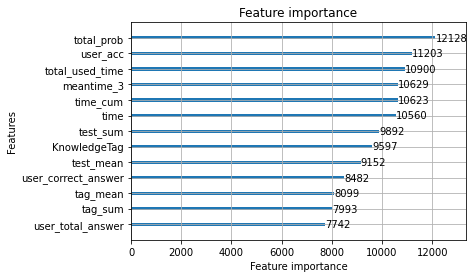

In [541]:
lgb.plot_importance(sk_lgb);

# 7. Prediction 분석

In [599]:
%%time
train2 = train.copy().reset_index()

y_value = pd.DataFrame()
for i in range(5):
    y = y_valids[i].to_frame('temp')
    y['proba'] = valid_result[i]
    y.drop('temp', 1, inplace=True)
    y.reset_index(inplace=True)
    y_value = pd.concat([y_value, y], 0)

train2 = pd.merge(train2, y_value, on='index', how='left')

CPU times: user 1.82 s, sys: 2.34 s, total: 4.16 s
Wall time: 4.17 s


In [601]:
len(train2) - train2['proba'].isna().sum()

6698

In [624]:
train2.to_csv('valid_set.csv', index=False)
test.to_csv('test_set.csv', index=False)

In [622]:
feature_pickle = 'feature_pickle.pickle'
with open(feature_pickle, 'wb') as f:
    pickle.dump(FEATURES, f)

In [604]:
df = train2[train2['proba'].isna() != True]
display(df.head(), df.shape)

,index,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold,time,temp_test,time_cum,test_group,total_used_time,meantime_3,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,proba
744,744,0,A080129006,80000129,0,2020-12-23 03:40:19,2725,0,5.0,1,287.0,8,32425.0,59.666667,470.0,744,0.631720,275.0,0.360111,780,0.301939,436,0.154803
1677,1677,1,A090074006,90000074,1,2020-11-13 02:47:20,2648,4,42.0,1,329.0,9,131336.0,55.333333,795.0,932,0.853004,138.0,0.425926,115,0.440741,119,0.829442
1953,1953,2,A050139007,50000139,0,2020-10-20 11:32:26,428,0,6.0,1,13.0,5,13910.0,2.666667,169.0,275,0.614545,107.0,0.627551,984,0.673578,2924,0.093734
2786,2786,5,A080138007,80000138,1,2020-12-11 22:48:28,8431,3,0.0,1,50.0,8,65138.0,9.333333,662.0,832,0.795673,171.0,0.504405,916,0.491346,511,0.561852
3707,3707,6,A030145005,30000145,0,2020-10-26 09:52:14,7817,3,24.0,1,203.0,3,43567.0,19.666667,408.0,920,0.443478,513.0,0.628679,833,0.617073,2530,0.560133


(6698, 23)

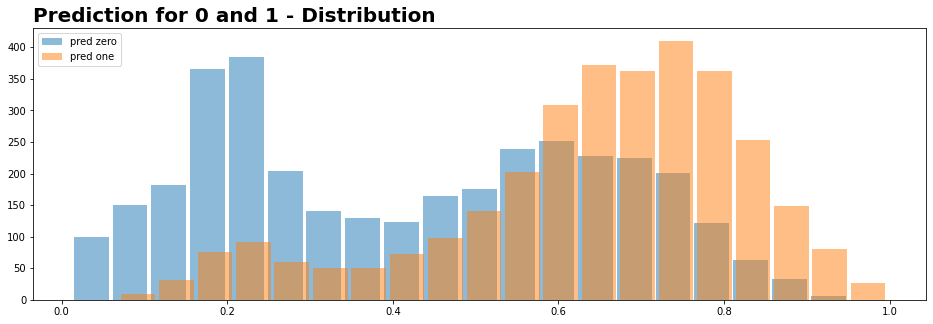

In [606]:
check_pred, check_zero, check_one = distribution_draw(df['answerCode'], df['proba'])
# X_valid_df 와 합쳐 학습에 이용된 data 와 정답률 분석하기
# check_df = pd.concat([X_valid_df, check_pred], axis=1)

In [615]:
# model save with joblib
import joblib

joblib.dump(sk_lgb, 'lgbm_model.pkl')
load_model = joblib.load('lgbm_model.pkl')
load_model

LGBMClassifier(n_estimators=500, num_leaves=255)

In [619]:
# model save with pickle
pickle_path = 'lgbm_python_model.pickle'
with open(pickle_path, 'wb') as f:
    pickle.dump(sk_lgb, f)
with open(pickle_path, 'rb') as f:
    load_python_model = pickle.load(f)
load_python_model

LGBMClassifier(n_estimators=500, num_leaves=255)

In [625]:
test_df

,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,time,time_cum,total_used_time,meantime_3
1035,5289,717.0,1035,0.692754,319.0,0.661765,90,0.542662,159,46.0,316.0,52955.0,27.000000
1706,9080,465.0,670,0.694030,206.0,0.740385,77,0.565693,155,23.0,172.0,58481.0,26.000000
3023,9660,915.0,1316,0.695289,402.0,0.417857,117,0.446753,172,8.0,104.0,165675.0,4.666667
4283,2611,1031.0,1259,0.818904,229.0,0.625000,30,0.514286,36,75.0,380.0,142672.0,75.000000
4670,1422,293.0,386,0.759067,94.0,0.678571,133,0.602767,305,17.0,275.0,12742.0,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,10615,7.0,23,0.304348,17.0,0.753846,147,0.654902,167,2.0,12.0,586.0,1.666667
260067,7636,7.0,14,0.500000,8.0,0.866667,156,0.834661,419,107.0,219.0,333.0,52.666667
260082,10402,7.0,14,0.500000,8.0,0.750000,75,0.792517,233,24.0,47.0,359.0,15.666667
260097,10402,2.0,14,0.142857,13.0,0.750000,75,0.792517,233,21.0,63.0,1242.0,21.000000


## Submission

In [608]:
submit = False
if submit:
    sub = pd.read_csv(sub_csv_file_path)
    sub['prediction'] = result[:,1]
    sub.to_csv(f"/opt/ml/output/lgbm_submission.csv", index=0)
    sub

In [11]:
sub = pd.read_csv(sub_csv_file_path)
sub.shape

(744, 2)

# 8. TODO
1. Feature engineering
2. parameter tuning
3. 정답을 맞춘 것에 따라 user 추출하기

In [ ]:
# # 과거에 문제 맞춘 횟수, 문제 푼 횟수, 문제별 평균 정답률 추가 : (LB 0.6935, 0.7570) -> 하락했으나 보류
# train['shift'] = train.groupby(['userID','assessmentItemID'])['answerCode'].shift(1).fillna(0)
# train['past_content_correct'] = train.groupby(['userID','assessmentItemID'])['shift'].cumsum()
# train['past_content_count'] = train.groupby(['userID','assessmentItemID']).cumcount()
# train['average_content_count'] = (train['past_content_correct']/train['past_content_correct']).fillna(0)

# test['shift'] = test.groupby(['userID','assessmentItemID'])['answerCode'].shift(1).fillna(0)
# test['past_content_correct'] = test.groupby(['userID','assessmentItemID'])['shift'].cumsum()
# test['past_content_count'] = test.groupby(['userID','assessmentItemID']).cumcount()
# test['average_content_count'] = (test['past_content_correct']/test['past_content_correct']).fillna(0)

# 과거의 어느 시점에 문제를 맞췄는지 여부
# train['correct_shift_-2'] = train.groupby('userID')['answerCode'].shift(-2)
# train['correct_shift_-1'] = train.groupby('userID')['answerCode'].shift(-1)
# train['correct_shift_2'] = train.groupby('userID')['answerCode'].shift(2)
# train['correct_shift_1'] = train.groupby('userID')['answerCode'].shift(1)

# test['correct_shift_-2'] = test.groupby('userID')['answerCode'].shift(-2)
# test['correct_shift_-1'] = test.groupby('userID')['answerCode'].shift(-1)
# test['correct_shift_2'] = test.groupby('userID')['answerCode'].shift(2)
# test['correct_shift_1'] = test.groupby('userID')['answerCode'].shift(1)

# test['correct_shift_-2'] = test['correct_shift_-2'].apply(lambda x: np.nan if x == -1 else x)
# test['correct_shift_-1'] = test['correct_shift_-1'].apply(lambda x: np.nan if x == -1 else x)
# # 과적합

# CV 기준으로는 하락

# median_dict = train.groupby('userID')['time'].agg('median').to_dict()
# train['time_median'] = train['userID'].map(median_dict)

# median_dict = test.groupby('userID')['time'].agg('median').to_dict()
# test['time_median'] = test['userID'].map(median_dict)

# # 그룹별로 난이도 차이가 나므로, 그룹별 시간 중간값을 추가해보자.
# median_dict = train.groupby(['userID','test_group'])['time'].agg('median').to_frame('group_time_median')
# train = pd.merge(train, median_dict, how='left', on = ['userID', 'test_group'])

# median_dict = test.groupby(['userID','test_group'])['time'].agg('median').to_frame('group_time_median')
# test = pd.merge(test, median_dict, how='left', on = ['userID', 'test_group'])

# 전체 통계 추가
# group_time_dict = train.groupby(['userID','test_group'])['time'].agg(['min','max','mean','median','std']).add_prefix('group_time_') # sum 은 이미 존재.
# train = pd.merge(train, group_time_dict, on = ['userID','test_group'], how='left')

# group_time_dict = test.groupby(['userID','test_group'])['time'].agg(['min','max','mean','median','std']).add_prefix('group_time_') # sum 은 이미 존재.
# test = pd.merge(test, group_time_dict, on = ['userID','test_group'], how='left')

# # 시간대별 정답률 : 0.7586, 0.5875, 0.6874, 0.7588
# train['hour'] = train['Timestamp'].dt.hour
# test['hour'] = test['Timestamp'].dt.hour
# test_stat['hour'] = test_stat['Timestamp'].dt.hour

# hour_ratio = train.groupby('hour')['answerCode'].mean().to_frame('hour_ratio')
# train = pd.merge(train, hour_ratio, on = 'hour', how='left')

# hour_ratio = test_stat.groupby('hour')['answerCode'].mean().to_frame('hour_ratio')
# test = pd.merge(test, hour_ratio, on = 'hour', how='left')

# mode_dict = train.groupby('userID')['hour'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
# train['hour_mode'] = train['userID'].map(mode_dict)

# mode_dict = test.groupby('userID')['hour'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
# test['hour_mode'] = test['userID'].map(mode_dict)

# train['is_night'] = (train['hour_mode'] > 15) & (train['hour_mode'] < 7)
# test['is_night'] = (test['hour_mode'] > 15) & (test['hour_mode'] < 7)

# median_dict = train.groupby('userID')['time'].agg('median').to_dict()
# train['time_median'] = train['userID'].map(median_dict)

# median_dict = test.groupby('userID')['time'].agg('median').to_dict()
# test['time_median'] = test['userID'].map(median_dict)

# train['relative_time'] = train['time_median'] - train['time']
# test['relative_time'] = test['time_median'] - test['time']